# Covariate-Assisted Embedding

In many network problems, our network might be more than just the information contained in its adjacency matrix - we might have extra information in the form of a set of covariates for each node. Covariate-Assisted Embedding (CASE) uses both these covariates and our adjacency matrix to create and embed a new representation of our network.

There are two primary reasons that we might want to explore using node covariates in addition to topological structure. First, they might improve our embedding if the latent structure of our covariates lines up with the latent structure of our adjacency matrix. Second, figuring out what the clusters of an embedding actually mean can sometimes be difficult - and covariates can create a natural structure.

To illustrate CASE, we'll use a model in which some of our community information is in the covariates and some is in our adjacency matrix. we’ll generate an SBM with three communities, with the first and second communities indistinguishable, then a set of covariates, with the second and third communities indistinguishable. Using CASE, we can find an embedding that lets us find distinct community structure.

### SBM

First, we sample a 3-block SBM with 1500 nodes, 500 nodes per community. We'll use the following block probability matrix:

\begin{align*}
B = 
\begin{bmatrix}
0.3 & 0.3 & .15 \\
0.3 & 0.3 & .15 \\
.15 & .15 & .3
\end{bmatrix}~
\end{align*}

Because $B$ has the same probability values in its upper-left $2 \times 2$ square, we'll see the nodes in communities one and two as a single giant block in our adjacency matrix. Nodes in community 3 are distinct. So, the end result is that we have three communities that we'd like to separate into distinct clusters, but the topological structure in the adjacency matrix can't separate the three groups by itself.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
np.random.seed(42)

import graspologic
from graspologic.simulations import sbm

# Start with some simple parameters
N = 1500  # Total number of nodes
n = N // 3  # Nodes per community
p, q = .3, .15
B = np.array([[p, p, q],
              [p, p, q],
              [q, q, p]])

# Sample from SBM
A, labels = sbm([n, n, n], B, return_labels = True)

Here you can see what our adjacency matrix looks like. Notice the giant block in the top-left: this block contains both nodes in both of the first two communities, and they're indistinguishable from each other.

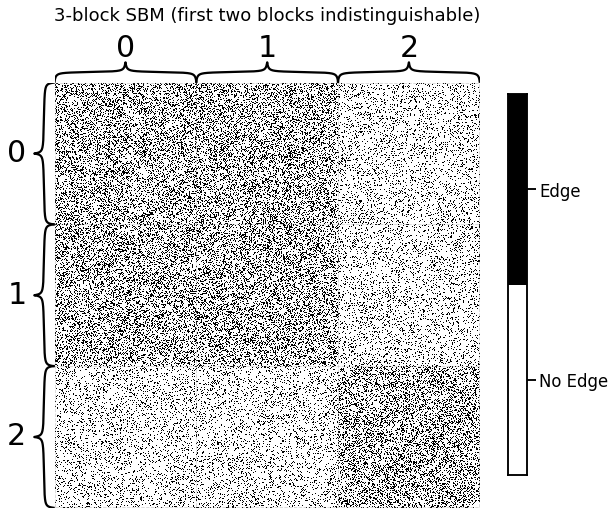

In [2]:
import matplotlib.pyplot as plt
from graspologic.plot import heatmap
import seaborn as sns
import matplotlib

# visualize
fig, ax = plt.subplots(figsize=(10,10))

def plot_heatmap(A, ax, title="3-block SBM (first two blocks indistinguishable)", show_cbar=True):
    cmap = matplotlib.colors.ListedColormap(["white", "black"])
    ax = heatmap(A, cmap=cmap, ax=ax, inner_hier_labels=labels, title=title, center=None)
    cbar = ax.collections[0].colorbar
    if show_cbar:
        cbar.set_ticks([0.25, .75])
        cbar.set_ticklabels(['No Edge', 'Edge'])
        cbar.ax.set_frame_on(True)
    else:
        cbar.remove()
            
        
plot_heatmap(A, ax)

If we wanted to embed this graph using LSE or ASE, we'd find the first and second communities layered on top of each other.

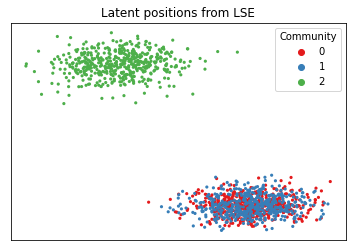

In [3]:
from graspologic.embed import LaplacianSpectralEmbed as LSE
from graspologic.utils import to_laplacian
from graspologic.plot import pairplot

L = to_laplacian(A, form="R-DAD")
L_latents = LSE(n_components=2).fit_transform(L)

def plot_latents(latent_positions, *, title, labels, ax=None):
    if ax is None:
        ax = plt.gca()
    plot = sns.scatterplot(latent_positions[:, 0], latent_positions[:, 1], hue=labels, 
                           linewidth=0, s=10, ax=ax, palette="Set1")
    plot.set_title(title, wrap=True);
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.legend(loc="upper right", title="Community")
    
    return plot

plot = plot_latents(L_latents, title="Latent positions from LSE", 
             labels=labels)

As you can see, we'd have a tough time clustering this. It would be nice if we could use extra information to more clearly distinguish between communities 0 and 1. We don't have this information in our adjacency matrix: it needs to come from our covariates.

### Covariates

Here, we sample a matrix of covariates. Each node is associated with its own group of 30 covariates. The $i_{th}$ row of $X$ contains the covariates associated with node $i$.

Covariates in community 1 will be drawn from a $Beta(2,5)$ distribution, whereas covariates in communities 2 or 3 will be drawn from a $Beta(2,2)$ distribution.

In [4]:
from scipy.stats import beta

def make_community(a, b, n=500):
    return beta.rvs(a, b, size=(n, 30))

def gen_covariates(n=500):
    c1 = make_community(2, 5, n=n)
    c2 = make_community(2, 2, n=n)
    c3 = make_community(2, 2, n=n)

    covariates = np.vstack((c1, c2, c3))
    return covariates
    

# Generate a covariate matrix
Y = gen_covariates()

Here is a visualization of the covariates we just created. 

On the left is the covariates themselves. The first community is represented by the 500 lighter-colored rows, and the last two are represented by the 1000 darker-colored rows. On the right is a function of the covariates, $\alpha XX^\top$, which is used in CASE for embedding.

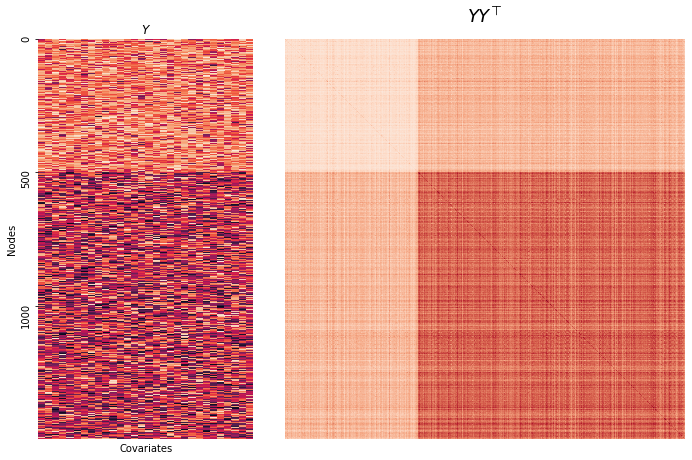

In [5]:
from matplotlib.gridspec import GridSpec

# Generate grid spec
fig = plt.figure(tight_layout=True, figsize=(10, 6.5))
gs = GridSpec(5, 6)
fig.add_subplot(gs[:, 0:2])
fig.add_subplot(gs[:, 2:])
axs = fig.axes

# Plot heatmaps
Y_ax = sns.heatmap(Y, ax=axs[0], cmap="rocket_r", cbar=False, yticklabels=500)
Y_ax.set(title=r"$Y$", xticks=[], 
       ylabel="Nodes",
       xlabel="Covariates");


YYt = Y@Y.T
aYYt = heatmap(YYt, title=r"$YY^\top$", ax=axs[1], cbar=False);

If we embed the information contained in this matrix of covariates, we can see the reverse situation as before - the first community is separate, but the last two are overlayed on top of each other.

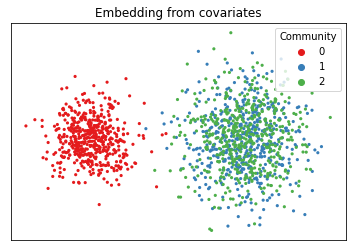

In [6]:
from sklearn.utils.extmath import randomized_svd

def embed(matrix, *, dimension):
    latents, _, _ = randomized_svd(matrix, n_components=dimension)
    return latents

Y_latents = embed(Y, dimension=2)

plot_latents(Y_latents, title="Embedding from covariates", 
             labels=labels);

Instead of the first and second communities being indistinguishable, the second and third now are. We'd like to see full separation between all three communities, so we need some kind of representation of our network that allows us to use both the information in the adjacency matrix and the information in the covariates.

## CASE

<i>Covariate-Assisted Spectral Embedding</i> is a simple way of combining our network and our covariates into a single model. In the most straightforward version of CASE, we sum the network's regularized Laplacian matrix $L$ and a function of our covariate matrix $XX^\top$. Here, $X$ is just our covariate matrix, in which row $i$ contains the covariates associated with node $i$.

$$
L + \alpha XX^\top
$$

$\alpha$ is multiplied by $XX^\top$ so that both matrices contribute an equal amount of useful information to the embedding. $\alpha$ defaults to the ratio of the largest eigenvalues of $L$ and $XX^\top$:

$$
\alpha = \frac{\lambda_1 (L)}{\lambda_1 (XX^\top)}
$$

This is the weight that causes $L$ and $XX^\top$ to contribute the same amount of information in their leading eigenspaces. 

Below, you can see graspologic's embedding of the weighted sum of the above two matrices. As you can see, the 3-community structure has been recovered by using both covariate information and topological information. Note that CASE accepts an adjacency matrix as its input into its `fit` method, not a Laplacian matrix.

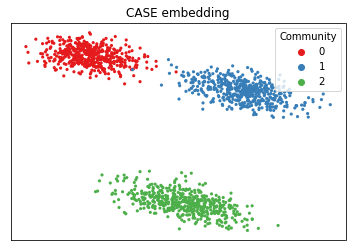

In [7]:
from graspologic.embed import CovariateAssistedEmbed as CASE

case = CASE(assortative=True, n_components=2)
latents = case.fit_transform((A, Y))
plot_latents(latents, title=r"CASE embedding", labels=labels);

### Exploring Possible Weights

Rather than simply letting the weight $\alpha$ be set automatically, you can also set a custom value. Below is a comparison of potential $\alpha$ values in our experimental setup. There are 9 possible $\alpha$ values, ranging between $10^{-5}$ and 100.

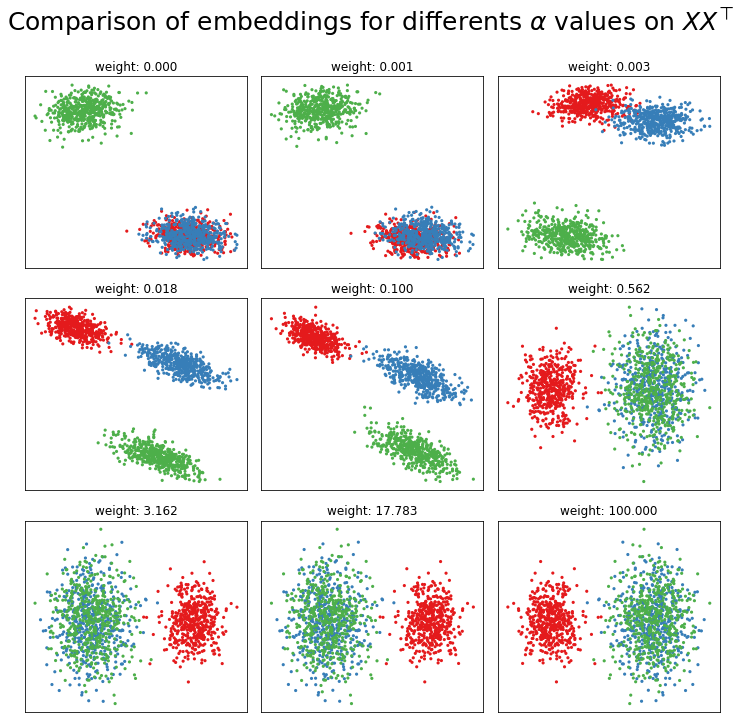

In [8]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
for a, ax in zip(np.geomspace(10e-5, 100, num=9), axs.flat):
    case = CASE(alpha=a, assortative=True, n_components=2)
    latents = case.fit_transform((A, Y))
    plot_latents(latents, title=f"weight: {a:.3f}", labels=labels, ax=ax)
    ax.get_legend().remove()

fig.suptitle(r"Comparison of embeddings for differents $\alpha$ values on $XX^\top$", 
             y=1, fontsize=25);
plt.tight_layout()

If we were to set the weight manually, it looks like we'd want a weight around 0.5. In practice, if the default weight is producing undesirable results, a shrewd data scientist could find a good weight by clustering with k-means or a GMM, then performing a line search (for example, `minimize_scalar` in scipy's [optimize](https://docs.scipy.org/doc/scipy/reference/optimize.html) module) on some metric which optimizes cluster separation, like BIC or sklearn's [silhouette score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html).

## Non-Assortative Graphs

If your graph is **non-assortative** - meaning, the between-block probabilities are greater than the within-block probabilities - it's better to square our Laplacian. This gets rid of a lot of annoying negative eigenvalues, and we end up embedding $LL + aXX^\top$. Below, you can see the embedding in the non-assortative case. In practice, if you don't know whether your graph is assortative or non-assortative, you can try both algorithms and use whichever one works best.

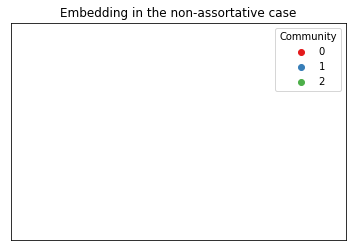

In [9]:
# generate a non-assortative adjacency matrix
p, q = .15, .3
B = np.array([[p, p, q],
              [p, p, q],
              [q, q, p]])
A, labels = sbm([n, n, n], B, return_labels = True)

# embed and plot
case = CASE(assortative=False, n_components=2)
latents = case.fit_transform((A, Y))
plot_latents(latents, title="Embedding in the non-assortative case", labels=labels);

In [10]:
latents

array([[-0.01894354,         nan],
       [-0.02217279,         nan],
       [-0.02045192,         nan],
       ...,
       [-0.02980948,         nan],
       [-0.02997218,         nan],
       [-0.02601225,         nan]])